# **Setup**

This is a testing and debugging notebook for condensate. Feel free to add more tests. E.g.:

- expected vortex densities using Feynman's rule
- feature tests such as time-varying potentials and scattering length
- Configurable to use local notebooks


In [35]:
## COLAB SETUP (DO NOT RUN THIS CELL LOCALLY):  Select the branch you would like to test
branch_name = 'feature/python'

%cd '/content'
!rm -rf condensate
print('Loading condensate branch '+ branch_name +' ...')
import os
os.system('git clone --branch '+ branch_name+' https://github.com/biswaroopmukherjee/condensate.git')
%cd condensate/condensate/core/
!apt-get install -qq libglew-dev swig. 
!ln -sf /usr/local/lib/python3.7/dist-packages/numpy/core/include/numpy /usr/include/numpy
!mkdir build
!./build.sh
%cd '/content/condensate/notebooks' 
print('Ready.')

##

/content
Loading condensate branch feature/python ...
/content/condensate/condensate/core
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found


In [36]:
import sys, os
sys.path.append(os.path.abspath('..'))
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
from copy import copy, deepcopy
from condensate import Wavefunction, Environment, hbar
from condensate.utils import linear, show_video, radial_profile, set_plt_font_size

set_plt_font_size(13)

#**Test ground state without rotation**


            Running condensate on 256x256 grid with:
            atom number: 1e+06 
            mass:        3.80e-26
        


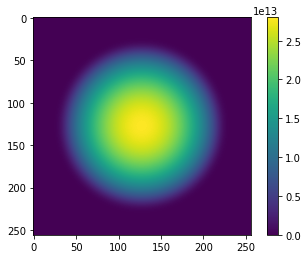

In [3]:
DIM = 256
fov = 400e-6
N = 1e6
omega = 2*np.pi
e = Environment(DIM=DIM, fov=fov, N=N)
e.harmonic_potential(omega=omega)

# Create a wavefunction with the environment
gs = Wavefunction(e)
gs.initialize_Psi(width=100)
gs.relax(dt=2e-4, steps=500, show=False)

gs.show_density()

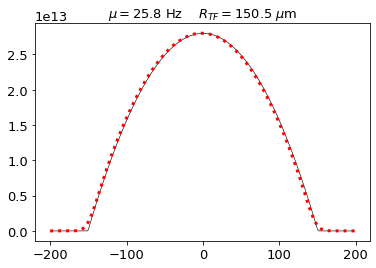

In [26]:
@np.vectorize
def n_thomas_fermi(x, n0, rtf):
  return n0 * max(1 - x**2 / rtf**2,0) 

profile = gs.density[DIM//2, :]
xs = np.arange(DIM) - DIM/2 
dx = fov / DIM
xs *= dx

f,_  = curve_fit(n_thomas_fermi, 1e6*xs, profile, [2.5e13, 150])
plt.plot(1e6*xs, n_thomas_fermi(1e6*xs, *f),'k-',lw=0.6)
plt.plot(1e6* xs, profile,'r:',lw=3)
mu = 0.5 * e.mass * omega**2 * (f[-1]*1e-6)**2
plt.title('$\\mu=$'+f'{mu/(2*np.pi*hbar):.1f} Hz    ' + '$R_{TF}=$'+f'{f[-1]:.1f}'+' $\mu$m')
plt.show()


#**Test vortices**

In [34]:
lattice = deepcopy(gs)
lattice.env.fov = 1e-3
lattice.env.rotating_frame(omegaR=0.94*omega)

lattice.relax(dt=1e-3, steps=4000, save_movie='figures/relax.mp4', vmax=1.2e7, showevery=60, show=False)
show_video('figures/relax.mp4')